In [8]:
# Place this as the FIRST cell, before importing torch.
import ast
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import ttest_rel, f_oneway
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
plt.style.use('BIEN.mplstyle')
plt.rcParams['svg.fonttype'] = 'none'
cmap = mpl.cm.get_cmap('tab10')

SEED = 1

# Seed Python, NumPy, Torch (CPU and CUDA)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Helpers for DataLoader reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

from pathlib import Path
from loguru import logger
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Subset
from src.datasets.seeg_dataset import SEEGDataset
from src.models.model import SEEGFusionModel, BaselineModel
from src.training.train import compute_class_weights, get_subject_indices
from src.training.evaluate import evaluate_model
from src.utils import load_yaml

config = load_yaml()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


/tmp/ipykernel_635361/1792135859.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab10')


In [2]:
# Create dataset once (loads all subjects)
sz_free_subjects=['Epat31','Epat35','Epat37','Epat38','Spat31','Spat37','Spat41','Spat42']
full_dataset = SEEGDataset(data_dir = '../data/processed', embed_dim=config['Parameters']['embed_dim'])

2025-12-05 15:16:43.007 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Spat41, n_targets=45, n_soz = 7, n_stim=53, n_resp=92, 


2025-12-05 15:16:43.220 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Spat37, n_targets=50, n_soz = 2, n_stim=53, n_resp=111, 
2025-12-05 15:16:43.452 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Spat52, n_targets=54, n_soz = 5, n_stim=61, n_resp=100, 
2025-12-05 15:16:43.660 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Epat30, n_targets=46, n_soz = 3, n_stim=62, n_resp=90, 
2025-12-05 15:16:43.773 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Epat31, n_targets=29, n_soz = 7, n_stim=40, n_resp=58, 
2025-12-05 15:16:43.876 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Spat42, n_targets=42, n_soz = 10, n_stim=44, n_resp=74, 
2025-12-05 15:16:44.081 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Spat48, n_targets=57, n_soz = 14, n_stim=67, n_resp=111, 
2025-12-05 15:16:44.257 | INFO     | src.datasets.seeg_dataset:__init__:40 - Loading subject Epat35, 

In [3]:
fusion_df = pd.read_csv('../results/Fusion_results_final_seed_1.csv', index_col=0)
fusion_df.sort_index(inplace=True)
fusion_df.drop(index='Spat55', inplace=True)  # subject has no SOZ electrodes
fusion_df['fpr'] = fusion_df['fpr'].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))
fusion_df['tpr'] = fusion_df['tpr'].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))
fusion_metric_dict = fusion_df.to_dict(orient='index')
fusion_df

,accuracy,auroc,f1,sensitivity,specificity,youden_index,optimal_threshold,fpr,tpr,best_epoch,train_loss
Epat26,0.849057,0.918605,0.692308,0.900000,0.837209,0.737209,0.585518,"[0.0, 0.0, 0.0, 0.046511627906976744, 0.046511...","[0.0, 0.1, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.8, ...",6,0.498536
Epat30,0.826087,0.899225,0.428571,1.000000,0.813953,0.813953,0.303319,"[0.0, 0.0, 0.11627906976744186, 0.116279069767...","[0.0, 0.3333333333333333, 0.3333333333333333, ...",6,0.482593
Epat31,0.931034,0.980519,0.875000,1.000000,0.909091,0.909091,0.451315,"[0.0, 0.0, 0.0, 0.045454545454545456, 0.045454...","[0.0, 0.14285714285714285, 0.7142857142857143,...",6,0.516851
Epat34,0.642857,0.687500,0.285714,1.000000,0.615385,0.615385,0.401870,"[0.0, 0.019230769230769232, 0.1730769230769230...","[0.0, 0.0, 0.0, 0.25, 0.25, 0.75, 0.75, 1.0, 1.0]",6,0.479069
Epat35,0.852941,0.875000,0.444444,1.000000,0.843750,0.843750,0.689743,"[0.0, 0.03125, 0.09375, 0.09375, 0.15625, 0.15...","[0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0]",6,0.465332
Epat37,0.803279,0.703571,0.333333,0.600000,0.821429,0.421429,0.361841,"[0.0, 0.017857142857142856, 0.0535714285714285...","[0.0, 0.0, 0.0, 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, ...",6,0.445363
Epat38,0.913043,0.923280,0.666667,1.000000,0.904762,0.904762,0.516426,"[0.0, 0.015873015873015872, 0.0476190476190476...","[0.0, 0.0, 0.0, 0.16666666666666666, 0.1666666...",6,0.473461
Epat39,0.815789,0.927273,0.588235,1.000000,0.787879,0.787879,0.384436,"[0.0, 0.0, 0.0, 0.15151515151515152, 0.1515151...","[0.0, 0.2, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0]",6,0.463654
Spat30,0.500000,0.589583,0.382979,0.900000,0.416667,0.316667,0.102041,"[0.0, 0.020833333333333332, 0.0416666666666666...","[0.0, 0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, ...",6,0.409905
Spat31,0.894737,0.885522,0.777778,0.636364,1.000000,0.636364,0.769199,"[0.0, 0.0, 0.0, 0.1111111111111111, 0.11111111...","[0.0, 0.09090909090909091, 0.6363636363636364,...",6,0.453487


In [4]:
baseline_df = pd.read_csv('../results/Baseline_results_final_seed_1.csv', index_col=0)
baseline_df.sort_index(inplace=True)
baseline_df.drop(index='Spat55', inplace=True)  # subject has no SOZ electrodes
baseline_df['fpr'] = baseline_df['fpr'].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))
baseline_df['tpr'] = baseline_df['tpr'].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))
baseline_metric_dict = baseline_df.to_dict(orient='index')
baseline_df

,accuracy,auroc,f1,sensitivity,specificity,youden_index,optimal_threshold,fpr,tpr,best_epoch,train_loss
Epat26,0.811321,0.281395,0.000000,0.000000,1.000000,0.000000,inf,"[0.0, 0.023255813953488372, 0.2093023255813953...","[0.0, 0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, ...",6,0.626193
Epat30,0.608696,0.806202,0.250000,1.000000,0.581395,0.581395,0.716104,"[0.0, 0.0, 0.16279069767441862, 0.162790697674...","[0.0, 0.3333333333333333, 0.3333333333333333, ...",6,0.609214
Epat31,0.896552,0.876623,0.769231,0.714286,0.954545,0.668831,0.579816,"[0.0, 0.0, 0.0, 0.045454545454545456, 0.045454...","[0.0, 0.14285714285714285, 0.2857142857142857,...",6,0.615759
Epat34,0.303571,0.528846,0.170213,1.000000,0.250000,0.250000,0.197123,"[0.0, 0.019230769230769232, 0.2115384615384615...","[0.0, 0.0, 0.0, 0.25, 0.25, 0.5, 0.5, 0.75, 0....",6,0.627377
Epat35,0.441176,0.406250,0.173913,1.000000,0.406250,0.406250,0.341984,"[0.0, 0.03125, 0.59375, 0.59375, 1.0]","[0.0, 0.0, 0.0, 1.0, 1.0]",6,0.615531
Epat37,0.836066,0.821429,0.444444,0.800000,0.839286,0.639286,0.575186,"[0.0, 0.017857142857142856, 0.0535714285714285...","[0.0, 0.0, 0.0, 0.2, 0.2, 0.4, 0.4, 0.8, 0.8, ...",6,0.630795
Epat38,0.753623,0.439153,0.190476,0.333333,0.793651,0.126984,0.467575,"[0.0, 0.015873015873015872, 0.1269841269841269...","[0.0, 0.0, 0.0, 0.16666666666666666, 0.1666666...",6,0.626563
Epat39,0.526316,0.618182,0.357143,1.000000,0.454545,0.454545,0.258265,"[0.0, 0.030303030303030304, 0.2121212121212121...","[0.0, 0.0, 0.0, 0.4, 0.4, 0.6, 0.6, 1.0, 1.0]",6,0.617603
Spat30,0.568966,0.591667,0.390244,0.800000,0.520833,0.320833,0.397205,"[0.0, 0.020833333333333332, 0.0208333333333333...","[0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, ...",6,0.630507
Spat31,0.763158,0.707071,0.571429,0.545455,0.851852,0.397306,0.381534,"[0.0, 0.0, 0.037037037037037035, 0.03703703703...","[0.0, 0.09090909090909091, 0.09090909090909091...",6,0.610907


In [5]:
print('Baseline model:')
for col in baseline_df.columns:
    if col not in ['fpr', 'tpr']:
        print(f'{col}: {baseline_df[col].mean():0.2f} +/- {baseline_df[col].std():0.2f}')
print('-----------------')
print('Fusion model:')
for col in fusion_df.columns:
    if col not in ['fpr', 'tpr']:
        print(f'{col}: {fusion_df[col].mean():0.2f} +/- {fusion_df[col].std():0.2f}')

Baseline model:
accuracy: 0.56 +/- 0.25
auroc: 0.55 +/- 0.25
f1: 0.30 +/- 0.21
sensitivity: 0.82 +/- 0.30
specificity: 0.55 +/- 0.30
youden_index: 0.37 +/- 0.24
optimal_threshold: inf +/- nan
best_epoch: 6.00 +/- 0.00
train_loss: 0.62 +/- 0.01
-----------------
Fusion model:
accuracy: 0.77 +/- 0.22
auroc: 0.79 +/- 0.22
f1: 0.54 +/- 0.26
sensitivity: 0.90 +/- 0.17
specificity: 0.76 +/- 0.24
youden_index: 0.66 +/- 0.26
optimal_threshold: 0.51 +/- 0.18
best_epoch: 6.00 +/- 0.00
train_loss: 0.46 +/- 0.02


In [6]:
outcomes_df = pd.read_csv('../data/outcomes.csv')
outcomes_df

,subj,type,outcome,targets,soz,n_stim,n_resp,percent_soz
0,Epat26,rns,non-responder,53,10,66,103,0.188679
1,Epat30,none,NaN,46,3,62,90,0.065217
2,Epat31,surgery,I-d,29,7,40,58,0.241379
3,Epat34,none,NaN,56,4,67,108,0.071429
4,Epat35,surgery,I-a,34,2,39,77,0.058824
5,Epat37,rns,responder,61,5,70,124,0.081967
6,Epat38,surgery,I-a,69,6,71,109,0.086957
7,Epat39,surgery,II-a,38,5,59,75,0.131579
8,Spat30,none,NaN,58,10,66,112,0.172414
9,Spat31,rns,responder,38,11,45,67,0.289474


In [7]:
localized_subjs = outcomes_df[outcomes_df.outcome.isin(['responder','I-a','I-b','I-c','I-d'])]['subj'].to_list()
unknown_subjs = outcomes_df[(outcomes_df.outcome == 'unknown') | (outcomes_df.outcome.isna())]['subj'].to_list()
nonlocalized_subjs = outcomes_df[~outcomes_df.subj.isin([*localized_subjs, *unknown_subjs])]['subj'].to_list()
classes = ['localized', 'non-localized', 'unknown']
mapping_dict = {}
for lst, outcome in zip((localized_subjs, nonlocalized_subjs, unknown_subjs), classes):
    for s in lst:
        mapping_dict[s] = outcome
fusion_df['outcome'] = fusion_df.index.map(mapping_dict)

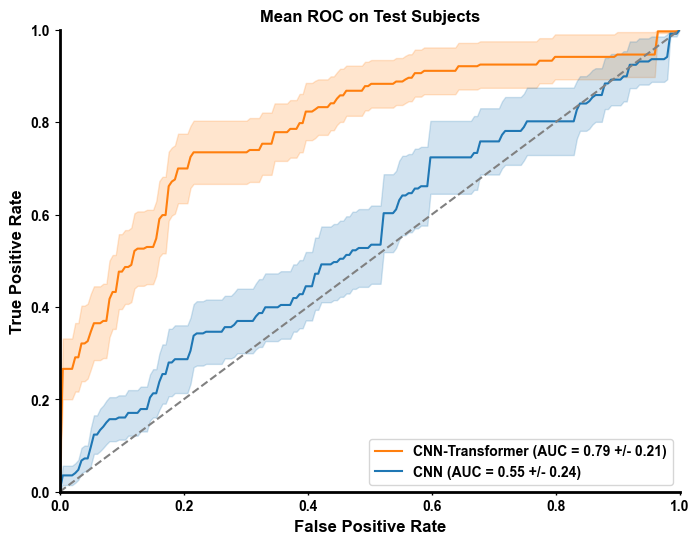

In [13]:
fpr_grid = np.linspace(0, 1, 200)
fusion_tpr_stack = []
baseline_tpr_stack = []

for subj, metrics in fusion_metric_dict.items():
    fpr = np.array(metrics['fpr'])
    tpr = np.array(metrics['tpr'])

    # --- INTERPOLATE OVER GRID ---
    tpr_interp = np.interp(fpr_grid, fpr, tpr, left=0.0, right=1.0)
    tpr_interp[0] = 0.0  # ensure it starts at 0
    tpr_interp[-1] = 1.0  # ensure it ends at 1
    fusion_tpr_stack.append(tpr_interp)

fusion_tpr_stack = np.vstack(fusion_tpr_stack)
fusion_mean_tpr = fusion_tpr_stack.mean(axis=0)
fusion_sem_tpr = fusion_tpr_stack.std(axis=0) / np.sqrt(len(fusion_tpr_stack))
fusion_mean_AUROC = np.mean([v['auroc'] for v in fusion_metric_dict.values()]).round(2)
fusion_std_AUROC = np.std([v['auroc'] for v in fusion_metric_dict.values()]).round(2)

for subj, metrics in baseline_metric_dict.items():
    fpr = np.array(metrics['fpr'])
    tpr = np.array(metrics['tpr'])

    # --- INTERPOLATE OVER GRID ---
    tpr_interp = np.interp(fpr_grid, fpr, tpr, left=0.0, right=1.0)
    tpr_interp[0] = 0.0  # ensure it starts at 0
    tpr_interp[-1] = 1.0  # ensure it ends at 1
    baseline_tpr_stack.append(tpr_interp)

baseline_tpr_stack = np.vstack(baseline_tpr_stack)
baseline_mean_tpr = baseline_tpr_stack.mean(axis=0)
baseline_sem_tpr = baseline_tpr_stack.std(axis=0) / np.sqrt(len(baseline_tpr_stack))
baseline_mean_AUROC = np.mean([v['auroc'] for v in baseline_metric_dict.values()]).round(2)
baseline_std_AUROC = np.std([v['auroc'] for v in baseline_metric_dict.values()]).round(2)

plt.figure(figsize=(8,6))
plt.plot(fpr_grid, fusion_mean_tpr, label=f'CNN-Transformer (AUC = {fusion_mean_AUROC} +/- {fusion_std_AUROC})', color=cmap(1))
plt.fill_between(fpr_grid, fusion_mean_tpr - fusion_sem_tpr, fusion_mean_tpr + fusion_sem_tpr, alpha=0.2, color=cmap(1))
plt.plot(fpr_grid, baseline_mean_tpr, label=f'CNN (AUC = {baseline_mean_AUROC} +/- {baseline_std_AUROC})', color=cmap(0))
plt.fill_between(fpr_grid, baseline_mean_tpr - baseline_sem_tpr, baseline_mean_tpr + baseline_sem_tpr, alpha=0.2, color=cmap(0))
plt.plot([0,1],[0,1], linestyle='--', color='gray')  # chance line
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Mean ROC on Test Subjects')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('../results/ROC_comparison.svg', dpi=300, bbox_inches='tight')

ANOVA F = 0.8271808501061635 p = 0.454132401077578
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
    localized non-localized  -0.1598 0.4307 -0.4828 0.1631  False
    localized       unknown  -0.0829 0.7523  -0.376 0.2103  False
non-localized       unknown    0.077 0.8245 -0.2547 0.4086  False
-----------------------------------------------------------------
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



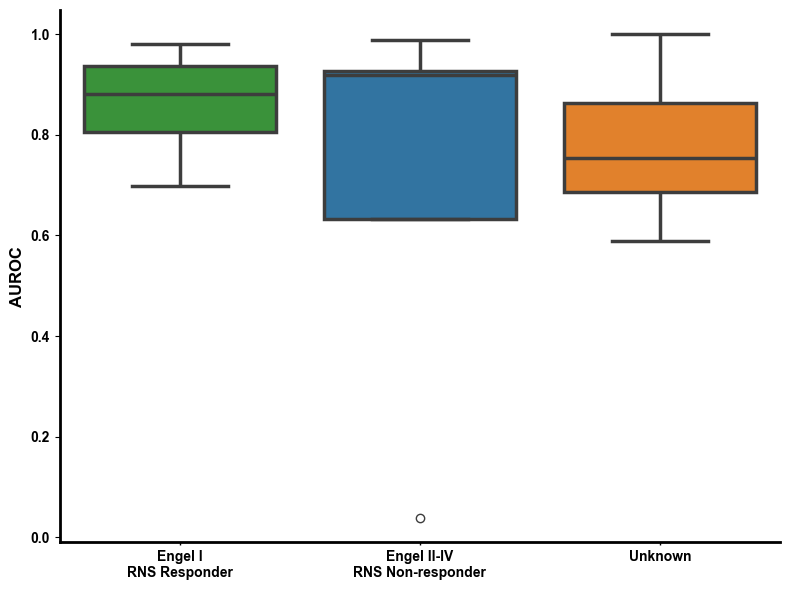

In [45]:
# --------------------------
# 1. One-way ANOVA
# --------------------------
groups = [group['auroc'].values for _, group in fusion_df.groupby('outcome')]
f_stat, p_val = f_oneway(*groups)
print("ANOVA F =", f_stat, "p =", p_val)

# --------------------------
# 2. Tukey HSD post-hoc
# --------------------------
if p_val < 0.5:
    tukey = pairwise_tukeyhsd(
        endog=fusion_df['auroc'],
        groups=fusion_df['outcome'],
        alpha=0.05
    )
    print(tukey)

    # Extract pairs and p-values for the plot
    pairs = []
    pvalues = []
    for res in tukey.summary().data[1:]:
        g1, g2, meandiff, p_adj, lower, upper, reject = res
        pairs.append((g1, g2))
        pvalues.append(p_adj)

# --------------------------
# 3. Plot with significance bars
# --------------------------
plt.figure(figsize=(8,6))
ax = sns.boxplot(
    data=fusion_df,
    x='outcome',
    y='auroc',
    hue='outcome',
    order=['localized', 'non-localized', 'unknown']
)
if p_val < 0.5:
    annotator = Annotator(ax, pairs, data=fusion_df, x='outcome', y='auroc')
    annotator.configure(test=None, hide_non_significant=True).set_pvalues(pvalues=pvalues).annotate()

plt.xlabel('')
plt.ylabel('AUROC')
ax.set_xticks(['localized', 'non-localized', 'unknown'])
ax.set_xticklabels(['Engel I\nRNS Responder', "Engel II-IV\nRNS Non-responder", "Unknown"])
plt.tight_layout()
plt.show()


In [51]:
baseline_long = (
    baseline_df
    .assign(model="baseline")
    .reset_index()
)
fusion_long = (
    fusion_df
    .assign(model="fusion")
    .reset_index()
)
combined = pd.concat([baseline_long, fusion_long], axis=0)
metrics = ['auroc', 'youden_index', 'f1', 'sensitivity', 'specificity']

plot_df = combined.melt(
    id_vars=["index", "model"],      # subject index & model label
    value_vars=metrics,              # metrics to plot
    var_name="metric",
    value_name="value"
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

youden_index_baseline vs. youden_index_fusion: t-test paired samples, P_val:2.055e-04 t=-4.578e+00
auroc_baseline vs. auroc_fusion: t-test paired samples, P_val:3.609e-04 t=-4.330e+00
f1_baseline vs. f1_fusion: t-test paired samples, P_val:1.025e-03 t=-3.873e+00
specificity_baseline vs. specificity_fusion: t-test paired samples, P_val:2.434e-03 t=-3.493e+00


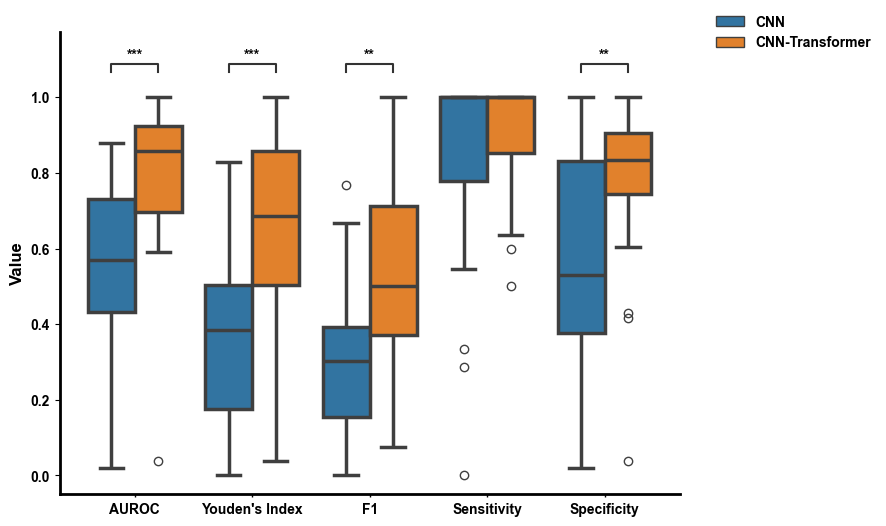

In [57]:
fig = plt.figure(figsize=(8,6))

ax = sns.boxplot(
    data=plot_df,
    x="metric",
    y="value",
    hue="model"
)

pairs=[
    (("auroc","baseline"), ("auroc", "fusion")),
    (("youden_index","baseline"), ("youden_index", "fusion")),
    (("f1","baseline"), ("f1", "fusion")),
    (("sensitivity","baseline"), ("sensitivity", "fusion")),
    (("specificity","baseline"), ("specificity", "fusion"))
]

annot = Annotator(
    ax,
    pairs=pairs,
    data=plot_df,
    x="metric",
    y="value",
    hue="model",
)
annot.configure(test='t-test_paired', hide_non_significant=True)
annot.apply_test()
annot.annotate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    ["CNN", "CNN-Transformer"],
    bbox_to_anchor=(1.05, 1),
    loc='center left',
    borderaxespad=0,
    frameon=False
)
ax.set_xticks(['auroc','youden_index','f1','sensitivity', 'specificity'])
ax.set_xticklabels(['AUROC', "Youden's Index", "F1", "Sensitivity", "Specificity"])
ax.set_xlabel('')
ax.set_ylabel('Value')
plt.savefig('../results/Metric_comparison.svg', bbox_inches='tight', dpi=300)